## **Estimación de costos de seguros médicos**

En el siguiente notebook se realiza la estimación de costos de seguros médicos.

Dataset disponible en: https://www.kaggle.com/datasets/mirichoi0218/insurance

### **1. Importación de librerias y de los datos**

In [77]:
# importar librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# herramientas
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# modelos
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
# escalamiento y normalizacion
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
# imputers
from sklearn.impute import SimpleImputer
# metricas
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# mejoras
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from scipy.stats import randint

In [78]:
# datos y conversion a dataframe
df = pd.read_csv('insurance.csv')
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [79]:
# df 
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [80]:
# tipos de datos
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

### **2. Análisis exploratorio de los datos**

En esta sección realiza un análisis exploratorio de los datos y posteriormente la limpieza de los datos en caso de ser necesario, como rellenar datos faltantes, igualar tipos de datos y encontrar datos duplicados.

In [81]:
# estadisticas
print("Estadistica descriptiva del dataset")
df.describe()

Estadistica descriptiva del dataset


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [82]:
# duplicados
df.duplicated().sum()

1

A continuacion se visualizan los valores únicos de las columnas categóricas.

In [83]:
# extraer las columnas tipo object
object_columns = df.select_dtypes(include=['object'])

# identificar sus valores unicos 
for column in object_columns:
    unique_values = object_columns[column].unique()
    print(f"Columna '{column}': {unique_values}")

Columna 'sex': ['female' 'male']
Columna 'smoker': ['yes' 'no']
Columna 'region': ['southwest' 'southeast' 'northwest' 'northeast']


Las variables de yes o no, como lo es la columna smoker, tienen comportamiento binario. Igualmente, la columna sex tiene un comportamiento binario.

A continuación se analizan los valores faltantes en las columnas y se buscan métodos para rellenarlos en caso de ser necesario.

In [84]:
# identificacion de datos faltantes con funcion proporcionada en clase
# cantidad de datos completos, sin NA, es decir, el total de datos
qsna=df.shape[0]-df.isnull().sum(axis=0)
# cantidad de datos que si son na
qna=df.isnull().sum(axis=0)
# proporcion de datos con na y sin na
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
# constuir la tab
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
# ordenar los valores de la tabla
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
age,1338,0,0.0
sex,1338,0,0.0
bmi,1338,0,0.0
children,1338,0,0.0
smoker,1338,0,0.0
region,1338,0,0.0
charges,1338,0,0.0


El dataset no contiene datos faltantes.

A continuación se verifica la distribución de los datos en las columnas numéricas.

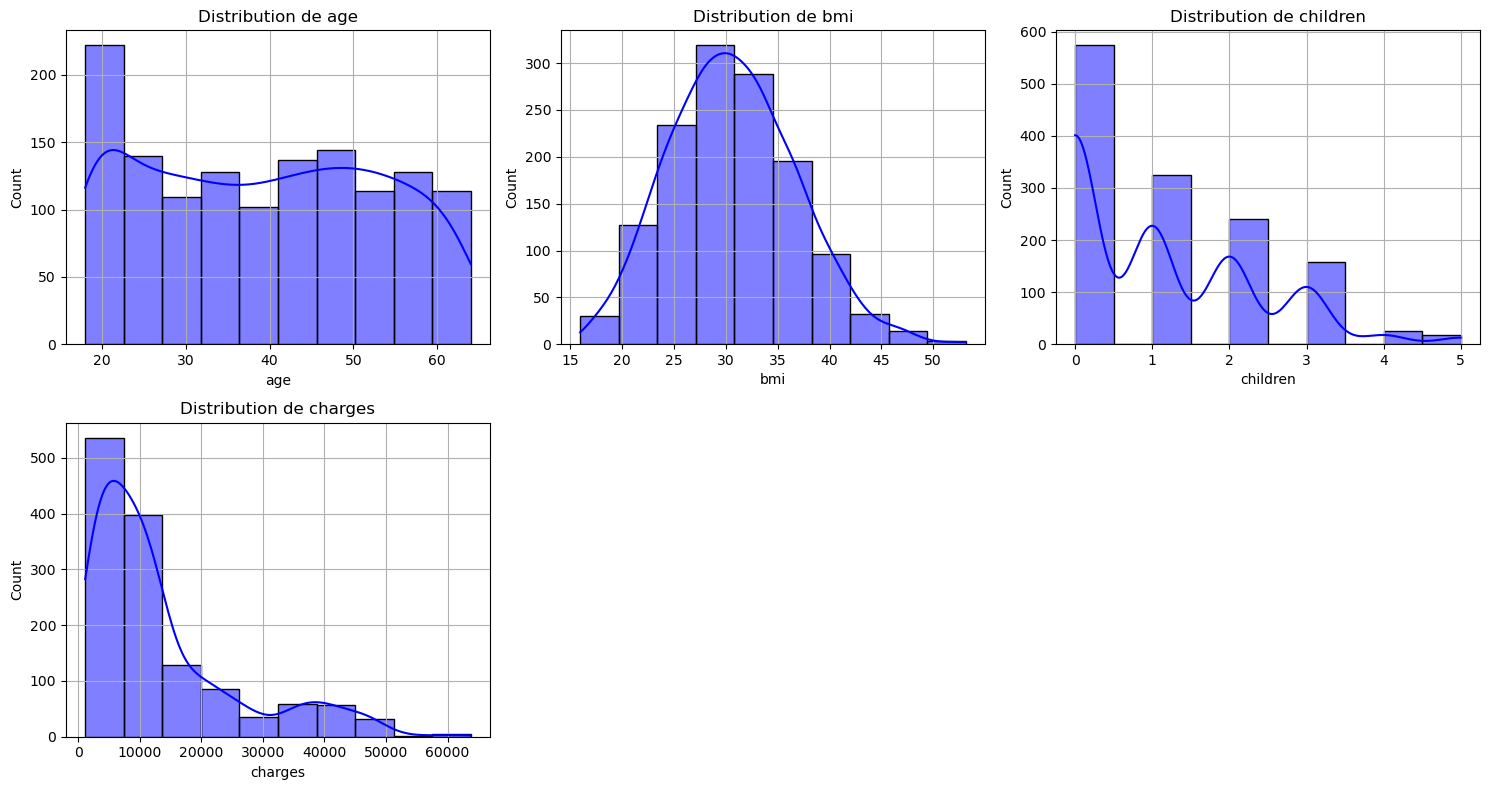

In [85]:
# numericas
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# numero de columnas y filas
cols = 3
filas = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)

# distribucion de los datos
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns, 1):
    # ajusta segun la cantidad de columnas
    plt.subplot(filas, cols, i) 
    sns.histplot(df[col], kde=True, color="blue", bins=10)  
    plt.title(f"Distribution de {col}")
    plt.tight_layout()
    plt.grid()

plt.show()

La variable de BMI presenta una distribución normal, mientras que charges está sesgada a la derecha con los valores bajos siendo los más frecuentes. 

Luego, se busca identificar outliers en las columnas numéricas.

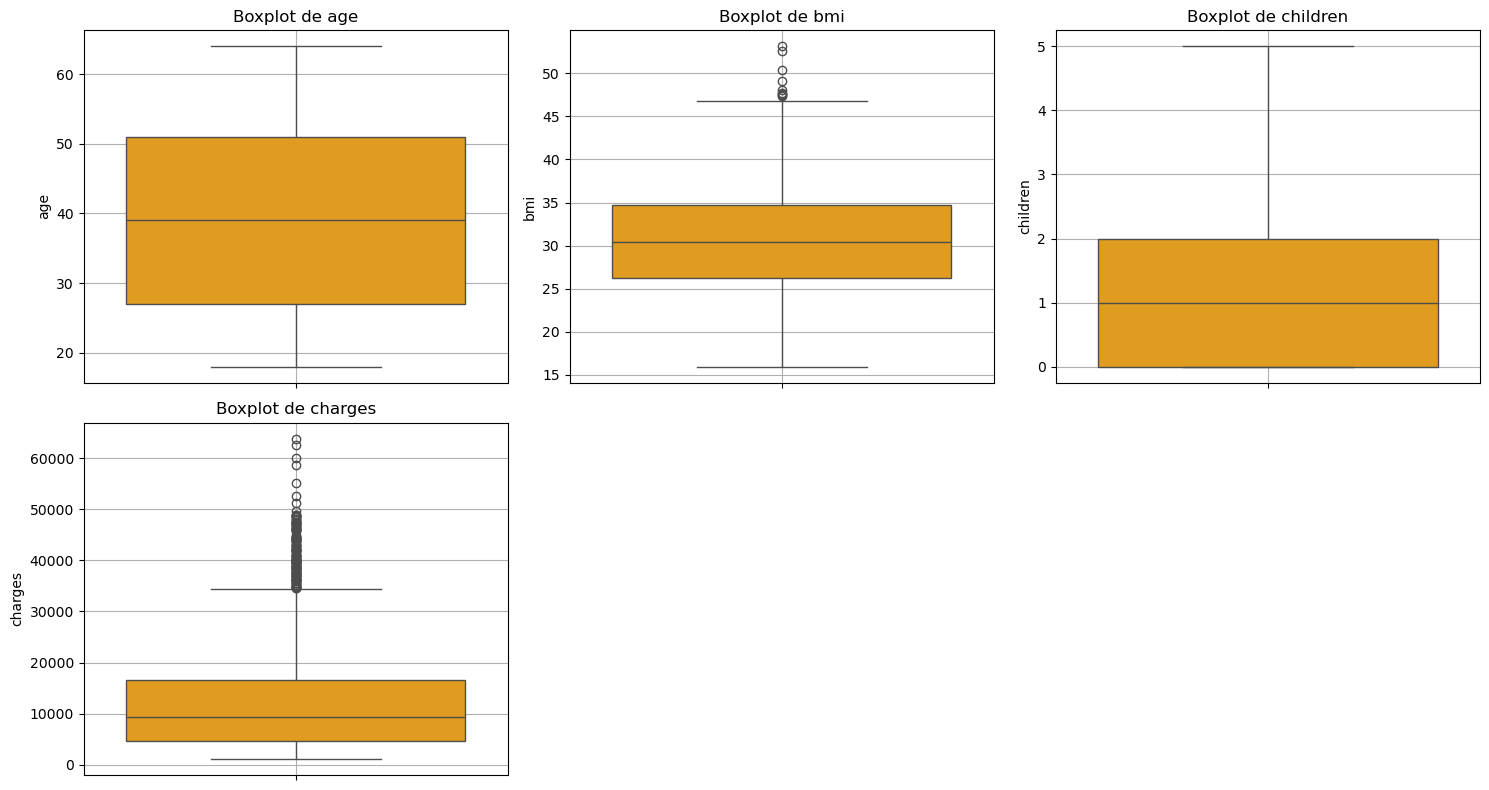

In [86]:
# numericas
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

# numero de columnas y filas
cols = 3
filas = (len(numerical_columns) // cols) + (len(numerical_columns) % cols > 0)

# crear boxplots 
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns, 1):
    # ajusta segun la cantidad de columnas
    plt.subplot(filas, cols, i) 
    sns.boxplot(y=df[col], color="orange")
    plt.title(f"Boxplot de {col}")
    plt.tight_layout()
    plt.grid()

plt.show()

Se visualizan outliers en BMI y charges. A fin de comprender los datos que son outliers en las columnas mencionadas se procede a extraer esos datos y determinar su procedencia.

In [87]:
# estadisticas 
print("Estadisticas de BMI: \n",df['bmi'].describe())
print("Estadisticas de charges: \n",df['charges'].describe())

Estadisticas de BMI: 
 count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64
Estadisticas de charges: 
 count     1338.000000
mean     13270.422265
std      12110.011237
min       1121.873900
25%       4740.287150
50%       9382.033000
75%      16639.912515
max      63770.428010
Name: charges, dtype: float64


In [88]:
# funcion para identificar outliers
def identificar_outliers(columna):
    q1 = df[columna].quantile(0.25)
    q3 = df[columna].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return df[(df[columna] < lower_bound) | (df[columna] > upper_bound)]

In [89]:
# verificar outliers
outliers_bmi = identificar_outliers('bmi')
outliers_charges = identificar_outliers('charges')

print("Outliers en BMI:")
print(outliers_bmi)
print("\nOutliers en Charges:")
print(outliers_charges)

Outliers en BMI:
      age     sex    bmi  children smoker     region      charges
116    58    male  49.06         0     no  southeast  11381.32540
286    46  female  48.07         2     no  northeast   9432.92530
401    47    male  47.52         1     no  southeast   8083.91980
543    54  female  47.41         0    yes  southeast  63770.42801
847    23    male  50.38         1     no  southeast   2438.05520
860    37  female  47.60         2    yes  southwest  46113.51100
1047   22    male  52.58         1    yes  southeast  44501.39820
1088   52    male  47.74         1     no  southeast   9748.91060
1317   18    male  53.13         0     no  southeast   1163.46270

Outliers en Charges:
      age     sex     bmi  children smoker     region      charges
14     27    male  42.130         0    yes  southeast  39611.75770
19     30    male  35.300         0    yes  southwest  36837.46700
23     34  female  31.920         1    yes  northeast  37701.87680
29     31    male  36.300        

Para los outliers de BMI vemos que la mayoria se trata de gente adulta, de al menos 40 años para arriba. La cantidad de outliers en charges es superior. El precio aumenta si la persona es fumadora. 

Considerando que el precio aumenta si la persona es fumadora, se realiza un boxplot de las columnas smoker y charges.

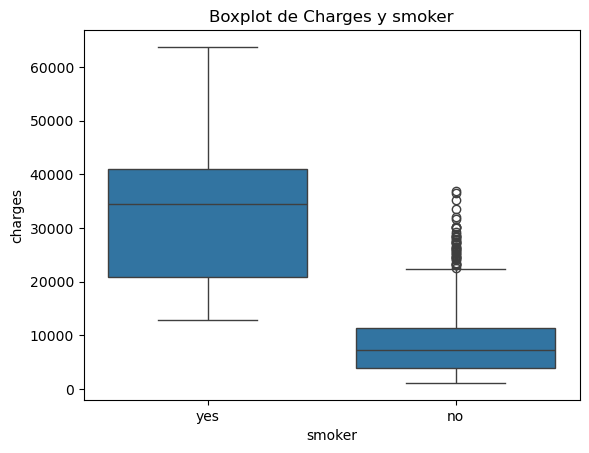

In [90]:
# boxplot de charges y smoker
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Boxplot de Charges y smoker')
plt.show()

En lineas generales se observa que las personas fumadoras tienen mayores costos de servicios médicos, mientras que los que no tienen menores costos. Por otro lado, los outliers se dan en las personas que no son fumadoras. 

Para verificar porque hay outliers en las personas que no son fumadoras se buscan otras posibles causas, como el numero de hijos o la edad.

In [91]:
# no smokers
non_smokers = df[df['smoker'] == 'no']

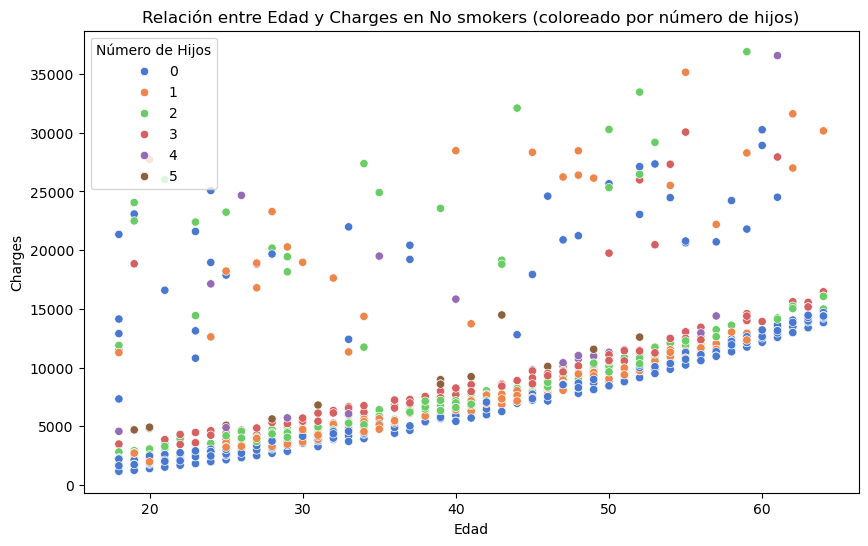

In [92]:
# edad vs charges 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='charges', data=non_smokers, hue='children', palette='muted')
plt.title('Relación entre Edad y Charges en No smokers (coloreado por número de hijos)')
plt.xlabel('Edad')
plt.ylabel('Charges')
plt.legend(title='Número de Hijos')
plt.show()

En el grafico de dispersion se observa una fuerte relacion entre la edad y el monto de los seguros, practicamente a medida que aumenta la edad, el costo del seguro aumenta. Por otro lado, tambien se agruparon los datos por cantidad de hijos, sin embargo los outliers o aquellos puntos que no estan conglomerados cercanos a las lineas, no muestran una tendencia de mas cantidad de hijos y mas edad implica mayor costo del seguro.

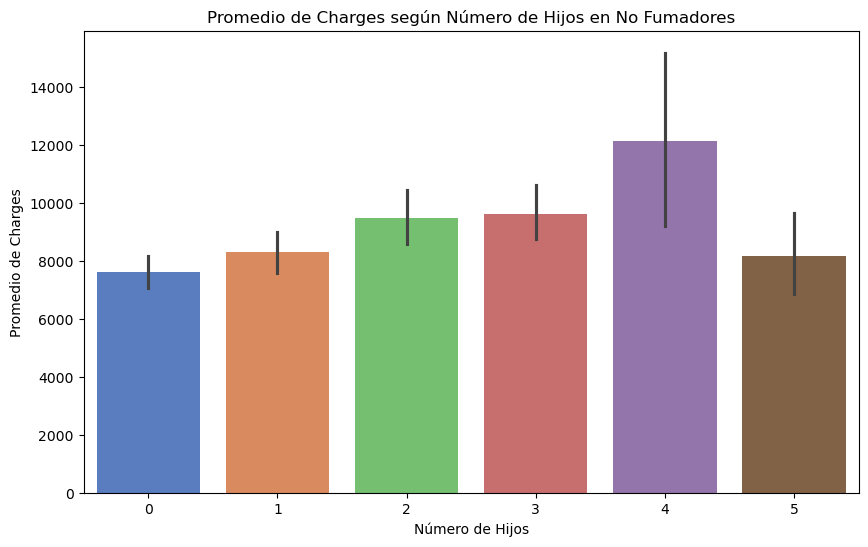

In [93]:
# children vs promedio charges
plt.figure(figsize=(10, 6))
sns.barplot(x='children', y='charges', data=non_smokers, estimator='mean', hue='children' , legend=False , palette='muted')
plt.title('Promedio de Charges según Número de Hijos en No Fumadores')
plt.xlabel('Número de Hijos')
plt.ylabel('Promedio de Charges')
plt.show()

En el grafico se visualiza que las personas que tengan 4 hijos tienen un costo promedio mayor de seguro médico. 

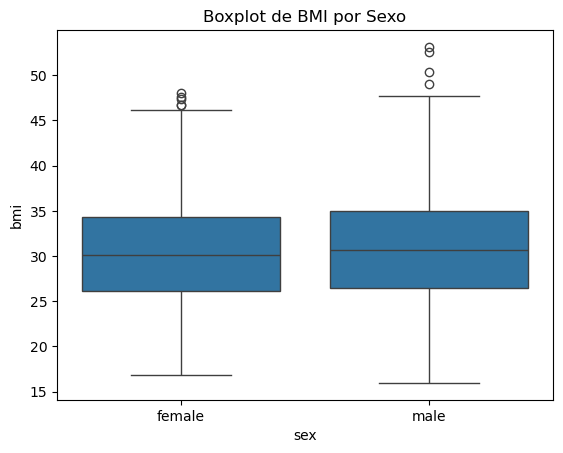

In [94]:
# boxplot de sex y bmi
sns.boxplot(x='sex', y='bmi', data=df)
plt.title('Boxplot de BMI por Sexo')
plt.show()

Para el analisis del bmi se grafica en el boxplot los outliers en contraste con el sexo. Aparentemente hay mas outliers en el sexo masculino, lo cual tambien puede estar relacionado con la edad.

Las variables categoricas del tipo binaria como sex y smoker seran convertidas a binarias. Es decir, 1 para la afirmacion y 0 para la negacion.

In [95]:
# categoricas binarias a numericas
df['sex'] = df['sex'].map({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})

In [96]:
# df
df.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region       object
charges     float64
dtype: object

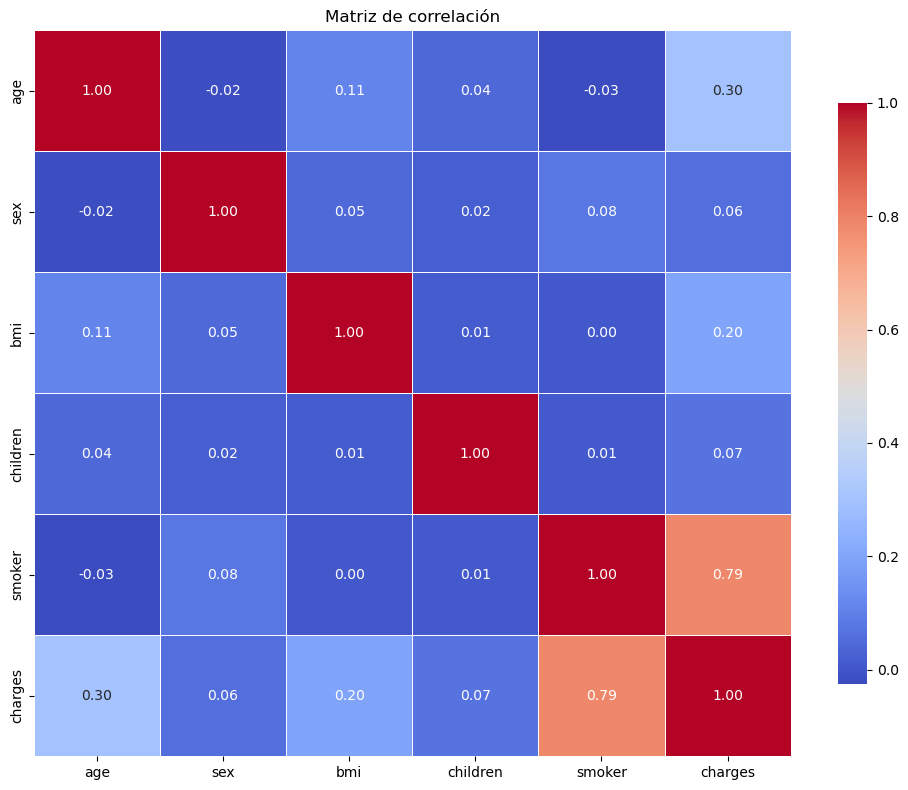

In [97]:
# variables numéricas
numerical_columns = df.select_dtypes(include=['int64','float64'])

# matriz de correlación
correlation_matrix = numerical_columns.corr()

# mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, linecolor='white', cbar_kws={"shrink": .8})
plt.title('Matriz de correlación')

# mostrar el grafico
plt.tight_layout()
plt.show()

La variable smoker presenta una alta correlacion con los costos de seguro médicos. 

### **3. Preprocesamiento de los datos**

El objetivo de aplicar modelos a este set de datos es el de estimar los costos de seguros médicos para las personas, de acuerdo a las características de las mismas.

Se realiza el preprocesamiento de los datos para luego ser utilizados en modelos.

In [98]:
#df
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [99]:
# df
df.head(5)

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


Como variable target es elegida 'charges' y como variables predictoras las restantes.

In [100]:
# variables categoricas y target
x = df.drop(columns=['charges'])  
y = df[['charges']]

In [101]:
# extraer columnas
numerical_features = x.select_dtypes(include=['int64', 'float64']).columns
categorical_features =x.select_dtypes(include=['object']).columns

# verificar
print("Features numericas: ", numerical_features)
print("Features numericas: ", categorical_features)

Features numericas:  Index(['age', 'sex', 'bmi', 'children', 'smoker'], dtype='object')
Features numericas:  Index(['region'], dtype='object')


Como imputer se utiliza la estrategia de la mediana, ya que algunos datos no siguen la distribución normal y con el objetivo de no alterar su distribución actual. Por otro lado, para el escalamiento se utilizará el min max scaler por la misma razón, ya que la mayoria de los datos no siguen una distribución normal. Por último, para las variables categóricas se utilizará el onehot encoder.

In [102]:
# transformadores para cada subconjunto de columnas
# numerico
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

# categorico
categoric_transformer =  Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [103]:
# crear columntransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),  
        ('cat', categoric_transformer, categorical_features)  
    ]
)

### **4. Aplicación de los modelos**

### **Modelo de regresión lineal**

Para predecir el costo de los seguros médicos se utilizará la regresión lineal.

In [104]:
# split del dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [105]:
# pipeline 
model_rlineal = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', LinearRegression())  
])

In [106]:
# ajustar a los datos de entrenamiento
model_rlineal.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['age', 'sex', 'bmi', 'children', 'smoker'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['region'], dtype='object'))])),
                ('regressor', LinearRegression())])

In [107]:
# realizar predicciones
y_pred = model_rlineal.predict(x_test)

In [108]:
# evaluación del modelo en conjunto de prueba
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados en el conjunto de prueba:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R²): {r2}")

Resultados en el conjunto de prueba:
Error absoluto medio (MAE): 4145.4505556275935
Error cuadrático medio (MSE): 33780509.57479165
Coeficiente de determinación (R²): 0.769611805436901


El modelo de regresión lineal da buenos resultados, con r2 = 0.76.

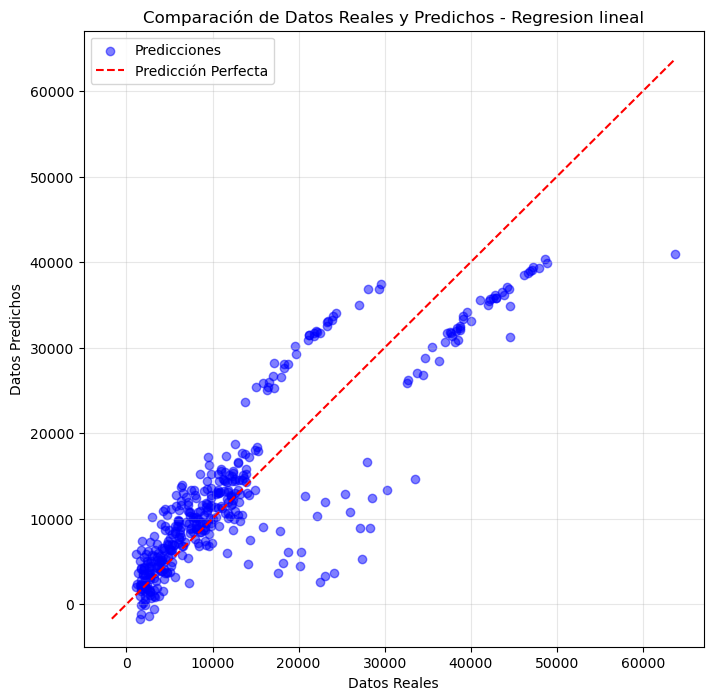

In [109]:
# convertir las series a una dimension
y_test = np.ravel(y_test)
y_test_pred = np.ravel(y_pred)

# gráfico
plt.figure(figsize=(8, 8))

# valores reales vs predichos
plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue', label='Predicciones')

# línea de referencia de predicción perfecta (predicho = real)
max_value = max(max(y_test), max(y_test_pred))
min_value = min(min(y_test), min(y_test_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Predicción Perfecta')

# configurar gráfico
plt.title('Comparación de Datos Reales y Predichos - Regresion lineal')
plt.xlabel('Datos Reales')
plt.ylabel('Datos Predichos')
plt.legend()
plt.grid(alpha=0.3)

# Mostrar el gráfico
plt.show()

El modelo de regresión lineal tiene buenas predicciones para valores bajos de charges, pero en valores más elevados tiene cierta tendencia a desviarse.

### **Modelo decission tree regressor**

Para estimar los costos de seguros médicos se utiliza el decission tree regressor.

In [110]:
# pipeline 
model_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', DecisionTreeRegressor(random_state=42))])

In [111]:
# ajustar a los datos de entrenamiento
model_tree.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['age', 'sex', 'bmi', 'children', 'smoker'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['region'], dtype='object'))])),
                ('regressor', DecisionTreeRegressor(random_state=42))])

In [112]:
# realizar predicciones
y_pred = model_tree.predict(x_test)

In [113]:
# evaluación del modelo en conjunto de prueba
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados en el conjunto de prueba:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R²): {r2}")

Resultados en el conjunto de prueba:
Error absoluto medio (MAE): 2868.010794773632
Error cuadrático medio (MSE): 40741846.440032914
Coeficiente de determinación (R²): 0.7221344330610473


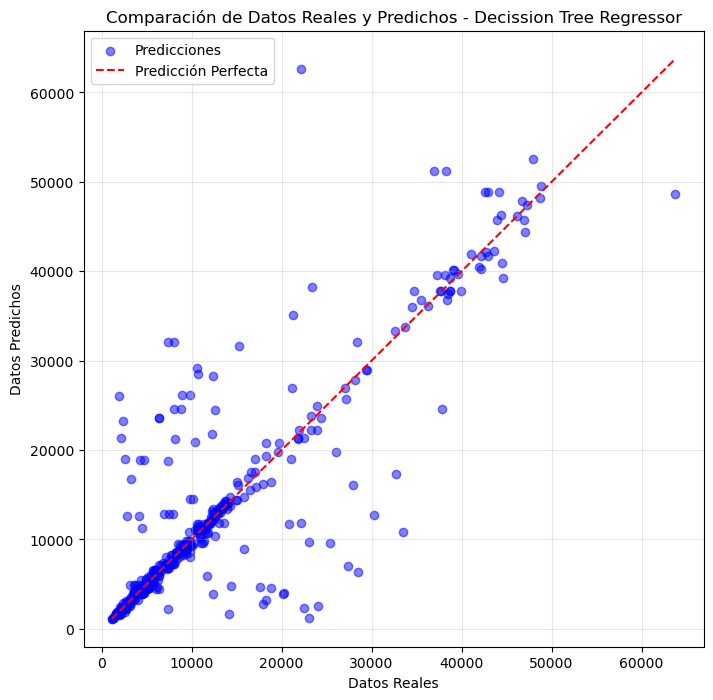

In [114]:
# convertir las series a una dimension
y_test = np.ravel(y_test)
y_test_pred = np.ravel(y_pred)

# gráfico
plt.figure(figsize=(8, 8))

# valores reales vs predichos
plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue', label='Predicciones')

# línea de referencia de predicción perfecta (predicho = real)
max_value = max(max(y_test), max(y_test_pred))
min_value = min(min(y_test), min(y_test_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Predicción Perfecta')

# configurar gráfico
plt.title('Comparación de Datos Reales y Predichos - Decission Tree Regressor')
plt.xlabel('Datos Reales')
plt.ylabel('Datos Predichos')
plt.legend()
plt.grid(alpha=0.3)

# Mostrar el gráfico
plt.show()

El modelo de decission trees regressor se aproxima mejor a las predicciones.

### **Modelo KNN regressor**

Para estimar los costos de seguros médicos de las personas, se utiliza el modelo KNN regressor.

In [115]:
# pipeline 
model_knn = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('regressor', KNeighborsRegressor(n_neighbors=3))])

In [116]:
# ajustar a los datos de entrenamiento
model_knn.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  Index(['age', 'sex', 'bmi', 'children', 'smoker'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['region'], dtype='object'))])),
                ('regressor', KNeighborsRegressor(n_neighbors=3))])

In [117]:
# realizar predicciones
y_pred = model_knn.predict(x_test)

In [118]:
# evaluación del modelo en conjunto de prueba
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados en el conjunto de prueba:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R²): {r2}")

Resultados en el conjunto de prueba:
Error absoluto medio (MAE): 3422.3589378134325
Error cuadrático medio (MSE): 32509777.831524193
Coeficiente de determinación (R²): 0.7782783884988652


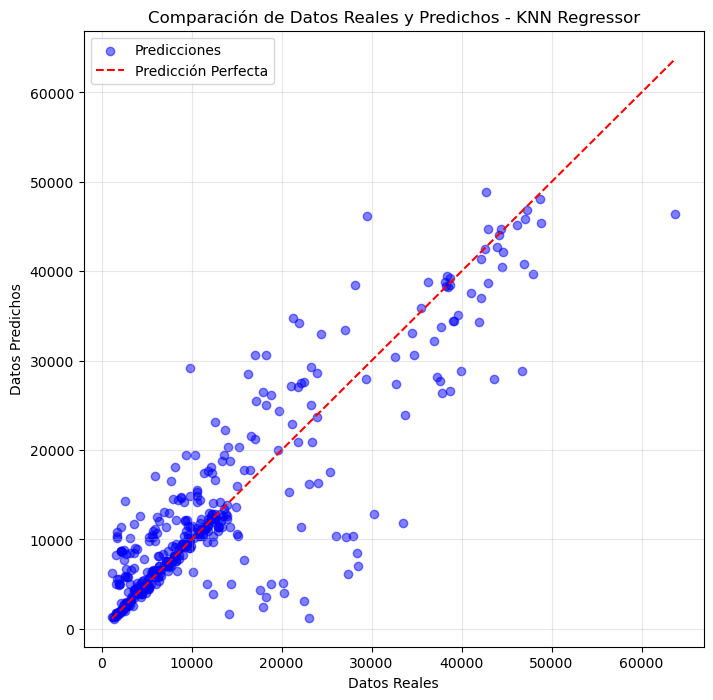

In [119]:
# convertir las series a una dimension
y_test = np.ravel(y_test)
y_test_pred = np.ravel(y_pred)

# gráfico
plt.figure(figsize=(8, 8))

# valores reales vs predichos
plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue', label='Predicciones')

# línea de referencia de predicción perfecta (predicho = real)
max_value = max(max(y_test), max(y_test_pred))
min_value = min(min(y_test), min(y_test_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Predicción Perfecta')

# configurar gráfico
plt.title('Comparación de Datos Reales y Predichos - KNN Regressor')
plt.xlabel('Datos Reales')
plt.ylabel('Datos Predichos')
plt.legend()
plt.grid(alpha=0.3)

# Mostrar el gráfico
plt.show()

De entre los 3 modelos aplicados, el modelo de KNN arroja ligeramente un mejor resultado en cuanto a las métricas, específicamente R2, con un valor de 0.77, le sigue el modelo de regresión lineal con R2 = 0.76 y por último de decission tree con R2 = 0.72. Sin embargo, en los gráficos se observan diferencias importantes entre los tres modelos. Inicialmente, el modelo de regresión lineal tiende a realizar mejores predicciones para los costos más bajos, mientras que para valores más elevados tiende a dispersarse un poco más. En cuanto al decission tree regressor, la gráfica sugiere que realiza buenas predicciones a lo largo de las lineas, se ajusta un poco mejor a la línea de referencia y el KNN tiene un comportamiento similar también. 

A continuación se realiza la validación cruzada de los modelos.

In [120]:
# modelos
models = {
    'Regresión Lineal': model_rlineal,
    'KNN': model_knn,
    'Árbol de Decisión': model_tree
}

# validacion cruzada
cv_results = {}

for model_name, model in models.items():
    # r2 metrica
    scores = cross_val_score(model, x, y, cv=5, scoring='r2')
    cv_results[model_name] = scores
    print(f"{model_name}:")
    print(f"  R² promedio: {scores.mean():.4f}")
    print(f"  Desviación estándar: {scores.std():.4f}")


Regresión Lineal:
  R² promedio: 0.7470
  Desviación estándar: 0.0249
KNN:
  R² promedio: 0.7506
  Desviación estándar: 0.0276
Árbol de Decisión:
  R² promedio: 0.7070
  Desviación estándar: 0.0414


Se busca mejorar los resultados del modelo de decission tree regressor con GridSearchCV y RandomizedSearchCV

In [125]:
# hiperparametros a probar
param_grid = {
    'regressor__max_depth': [3, 5, 10, None],  
    'regressor__min_samples_split': [2, 5, 10],  
    'regressor__min_samples_leaf': [1, 2, 4],  
    'regressor__max_features': [None, 'sqrt', 'log2']  
}

In [126]:
# GridSearchCV
grid_search = GridSearchCV(
    model_tree, 
    param_grid,  
    cv=5,  
    scoring='r2', 
    n_jobs=-1, 
    verbose=1  
)

In [127]:
# buscar en train
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         Index(['age', 'sex', 'bmi', 'children', 'smoker'], dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['region'], dtype='object'))])),
                                       ('regressor',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [3, 5, 10, None],
                         'regressor__max_features': [None, 'sqrt', 'log2'],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10]},
             scoring='r2', verbose=1)

In [128]:
# resultados
print("Mejores parámetros:", grid_search.best_params_)
print("Mejor R² en validación cruzada:", grid_search.best_score_)

Mejores parámetros: {'regressor__max_depth': 3, 'regressor__max_features': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Mejor R² en validación cruzada: 0.8305729932232531


In [129]:
# modelo ajustado
best_tree_model = grid_search.best_estimator_

In [130]:
# realizar predicciones
y_pred = best_tree_model.predict(x_test)

In [131]:
# evaluación del modelo en conjunto de prueba
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados en el conjunto de prueba:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R²): {r2}")

Resultados en el conjunto de prueba:
Error absoluto medio (MAE): 2878.460403612174
Error cuadrático medio (MSE): 22877590.79048474
Coeficiente de determinación (R²): 0.8439713638273123


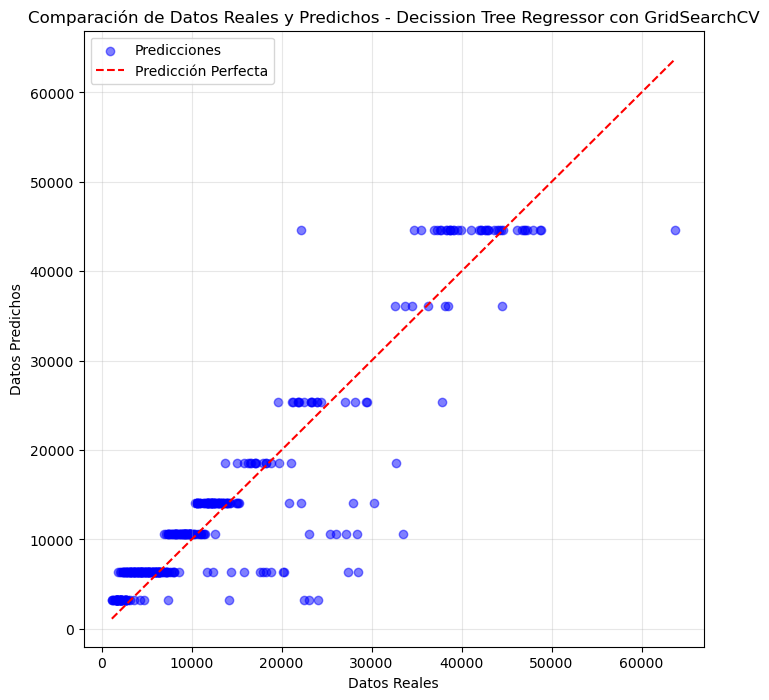

In [132]:
# convertir las series a una dimension
y_test = np.ravel(y_test)
y_test_pred = np.ravel(y_pred)

# gráfico
plt.figure(figsize=(8, 8))

# valores reales vs predichos
plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue', label='Predicciones')

# línea de referencia de predicción perfecta (predicho = real)
max_value = max(max(y_test), max(y_test_pred))
min_value = min(min(y_test), min(y_test_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Predicción Perfecta')

# configurar gráfico
plt.title('Comparación de Datos Reales y Predichos - Decission Tree Regressor con GridSearchCV')
plt.xlabel('Datos Reales')
plt.ylabel('Datos Predichos')
plt.legend()
plt.grid(alpha=0.3)

# Mostrar el gráfico
plt.show()

A continuación se aplica RandomizedSearchCV para mejorar el modelo de decission tree regressor.

In [133]:
# hiperparametros
param_dist = {
    # profundidad
    'regressor__max_depth': [None, 3, 5, 10, 20], 
    # muestras
    'regressor__min_samples_split': randint(2, 10), 
    # hojas
    'regressor__min_samples_leaf': randint(1, 10),  
    # caracteristicas
    'regressor__max_features': ['sqrt', 'log2', None]  
}

In [134]:
# RandomizedSearchCV
random_search = RandomizedSearchCV(
    model_tree,  
    param_distributions=param_dist, 
    n_iter=100,  
    cv=5,  
    scoring='r2',
    n_jobs=-1,  
    random_state=42, 
    verbose=2,  
    error_score='raise' 
)

In [135]:
# buscar en train
random_search.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               Index(['age', 'sex', 'bmi', 'children', 'smoker'], dtype='object')),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')...
                   param_distributions={'regressor__max_depth': [None, 3, 5, 10,
                                                                 20],
                                        'regressor__max_features': ['sqrt',
                                                                    'log2',
                                                                    None],
                                        'regressor__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000230F13C9D90>,
                                        'regressor__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000230F232F1D0>},
                   random_state=42, scoring='r2', verbose=2)

In [136]:
# resultados
print("Mejores parámetros:", random_search.best_params_)
print("Mejor R² en validación cruzada:", random_search.best_score_)

Mejores parámetros: {'regressor__max_depth': 5, 'regressor__max_features': None, 'regressor__min_samples_leaf': 9, 'regressor__min_samples_split': 2}
Mejor R² en validación cruzada: 0.8330966926971168


In [137]:
# modelo ajustado
best2_tree_model = random_search.best_estimator_

In [138]:
# realizar predicciones
y_pred = best2_tree_model.predict(x_test)

In [139]:
# evaluación del modelo en conjunto de prueba
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados en el conjunto de prueba:")
print(f"Error absoluto medio (MAE): {mae}")
print(f"Error cuadrático medio (MSE): {mse}")
print(f"Coeficiente de determinación (R²): {r2}")

Resultados en el conjunto de prueba:
Error absoluto medio (MAE): 2627.275241206626
Error cuadrático medio (MSE): 20437289.125158887
Coeficiente de determinación (R²): 0.8606145910000396


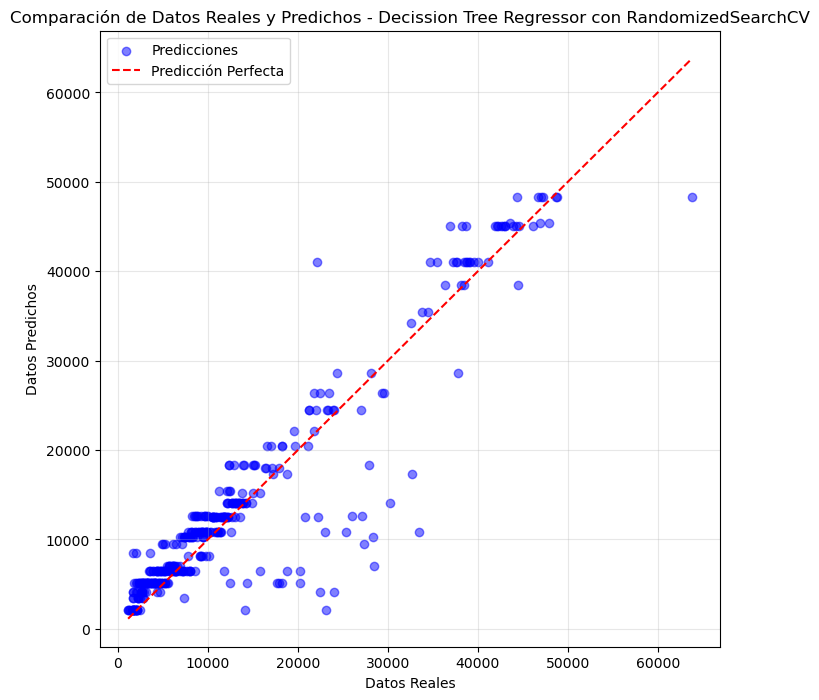

In [140]:
# convertir las series a una dimension
y_test = np.ravel(y_test)
y_test_pred = np.ravel(y_pred)

# gráfico
plt.figure(figsize=(8, 8))

# valores reales vs predichos
plt.scatter(y_test, y_test_pred, alpha=0.5, color='blue', label='Predicciones')

# línea de referencia de predicción perfecta (predicho = real)
max_value = max(max(y_test), max(y_test_pred))
min_value = min(min(y_test), min(y_test_pred))
plt.plot([min_value, max_value], [min_value, max_value], color='red', linestyle='--', label='Predicción Perfecta')

# configurar gráfico
plt.title('Comparación de Datos Reales y Predichos - Decission Tree Regressor con RandomizedSearchCV')
plt.xlabel('Datos Reales')
plt.ylabel('Datos Predichos')
plt.legend()
plt.grid(alpha=0.3)

# Mostrar el gráfico
plt.show()

Aplicando gridsearchcv y randomizedsearchcv se mejoró el modelo de árboles de decision. Así se observa que tuvo un mejor resultado el randomizedsearch cv ya que con el otro modelo se observa que la función termino siendo escalada.